In [76]:
import pandas as pd
import cv2
import numpy as np
from PIL import Image
from numba.experimental import jitclass
import os

In [22]:
rgb_data = pd.read_csv('data/avg_database.csv')
rgb_data

,Filename,R Average,G Average,B Average
0,2387492.jpg,89.918486,89.918486,89.918486
1,2410093.jpg,91.098584,83.267644,77.540491
2,2347873.jpg,152.236246,105.570771,79.500146
3,2413922.jpg,155.305904,144.017813,147.832432
4,2378712.jpg,133.415232,138.774533,145.682565
...,...,...,...,...
108074,2407870.jpg,158.935063,155.564372,146.570234
108075,2406600.jpg,105.070171,97.614688,76.548277
108076,498316.jpg,119.559224,118.338333,119.844109
108077,2386180.jpg,122.499445,116.810955,103.941269


In [23]:
def calc_l2_dist(a, b, c, x, y, z):  
    return (abs(int(a)-int(x)) + abs(b-y) + abs(c-z))

In [43]:
def remove_duplicate(data, image):
    vals = (data['Filename']==image[0]).values
    idx = np.where(vals == True)
    idx = int(idx[0])
    data = data.drop([idx])
    
    return data

In [74]:
def find_nearest_img(r, g, b, data):
    curr_dist = np.inf
    curr_img = None
    
    for img in data.values:
        dist = calc_l2_dist(r, g, b, img[1], img[2], img[3])
        if dist < curr_dist:
            curr_dist = dist
            curr_img = img
            
    # data = remove_duplicate(data, curr_img)
    file = curr_img[0]
    
    # remove dupes
    data = data.drop(data.index[data['Filename'] == file].tolist())
    return file, data

In [68]:
def construct_mosaic(pixel_batch, r, g, b, data):
    # create empty matrix of target image size
    mosaic = np.zeros((r.shape[0], r.shape[1], 3))
    
    max_x = r.shape[0]/pixel_batch
    max_y = r.shape[1]/pixel_batch
    print('max images along x: ', max_x)
    print('max images along y: ', max_y)
    
    # iterate through RGB and find the closest related image
    for x in range(0, r.shape[0], pixel_batch):
        for y in range(0, r.shape[1], pixel_batch):

            # need to handle padding issues later
            r_batch = r[x:x+pixel_batch, y:y+pixel_batch]
            g_batch = b[x:x+pixel_batch, y:y+pixel_batch]
            b_batch = g[x:x+pixel_batch, y:y+pixel_batch]
            
            # computer batch averages
            r_avg = np.mean(r_batch)
            g_avg = np.mean(g_batch)
            b_avg = np.mean(b_batch)
            
            # find the closest image
            # returns the filename
            img,data = find_nearest_img(r_avg, b_avg, g_avg, data)
            tmp_img_name = img
            # print(len(data))
            
            # extract the filename
            # img = img[0]
            img = Image.open('data/images/'+img)
            tmp_img = img
            
            # resize the image to be the batch size
            img = img.resize((pixel_batch, pixel_batch))#, Image.ANTIALIAS)
            
            # Convert to opencv image
            img = np.array(img) 
            try:
                img = img[:, :, ::-1].copy() 
            except:
                print(tmp_img_name)
                tmp_img.show()
            
            # add the image to the mosaic
            mosaic[x:x+pixel_batch, y:y+pixel_batch, 0] = img[:,:,2]
            mosaic[x:x+pixel_batch, y:y+pixel_batch, 1] = img[:,:,1]
            mosaic[x:x+pixel_batch, y:y+pixel_batch, 2] = img[:,:,0]
    
    out = Image.fromarray(mosaic.astype(np.uint8))
    return out

In [64]:
#read in the target image and divide it into RGB channels
def extract_rgb(target):
    image = cv2.imread(target)
    b,g,r = cv2.split(image)

    print('R: ', r.shape)
    print('G: ', g.shape)
    print('B: ', b.shape)
    
    return[r, g, b]

In [ ]:
# assign a pixel batch size
pixel_batch = 50
data = rgb_data.copy()
target = 'data/flower.jpg'

r,g,b = extract_rgb(target)
image = construct_mosaic(pixel_batch, r, g, b, data)
image.show()
image.save('data/flower_norepeats_pb50.jpg')

R:  (1200, 1600)
G:  (1200, 1600)
B:  (1200, 1600)
max images along x:  60.0
max images along y:  80.0
2338347.jpg


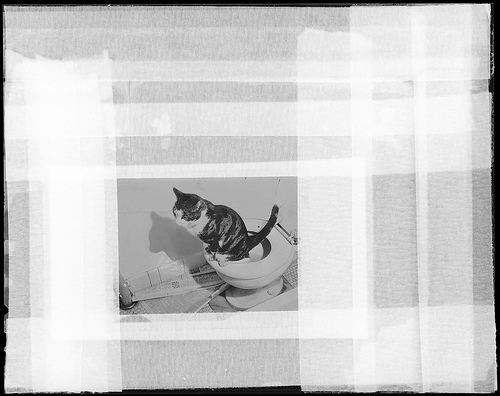

IndexError: too many indices for array

In [69]:
pixel_batch = 20
data = rgb_data.copy()
target = 'data/flower.jpg'

r,g,b = extract_rgb(target)
image = construct_mosaic(pixel_batch, r, g, b, data)
image.show()
image.save('dataflower_norepeats_pb20.jpg')

In [ ]:
pixel_batch = 10
data = rgb_data.copy()
target = 'data/flower.jpg'

r,g,b = extract_rgb(target)
image = construct_mosaic(pixel_batch, r, g, b, data)
image.show()
image.save('data/flower_norepeats_pb10.jpg')

In [75]:
pixel_batch = 10
data = rgb_data.copy()

for frame in os.listdir('data/videos/bunny_frames/'):
    # print(frame)
    file = 'data/videos/bunny_frames/' + frame
    r,g,b = extract_rgb(file)
    image = construct_mosaic(pixel_batch, r, g, b, data)
    regex = re.compile(r'\d+')
    frame_num = regex.findall(frame)[0]
    image.save('data/videos/mosaic_bunny_frames/frame%d.jpg' % frame_num)

NameError: name 'os' is not defined

In [73]:
idx = data.index[data['Filename'] == '2338347.jpg'].tolist()
data.loc[idx]

,Filename,R Average,G Average,B Average
52654,2338347.jpg,203.114833,203.114833,203.114833
